# Twitter US Airline Sentiment Analysis

In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Exploratory Data Analysis

In [2]:
tweets = pd.read_csv('tweets.csv')

In [3]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# split the entire dataframe into pos, neg and neu dataframe

filters = [tweets['airline_sentiment'] == x for x in ['positive', 'negative', 'neutral']]

pos, neg, neu = (tweets[f] for f in filters)

for df in pos, neg, neu:
    print(df.shape)

(2363, 15)
(9178, 15)
(3099, 15)


### Which US Airline provide better services relative to others?
Worst and best airline based on number of positive/negative tweets

In [5]:
# Worst airlines
worst = neg['airline'].value_counts()
worst

United            2633
US Airways        2263
American          1960
Southwest         1186
Delta              955
Virgin America     181
Name: airline, dtype: int64

In [6]:
# Best airlines
best = pos['airline'].value_counts()
best

Southwest         570
Delta             544
United            492
American          336
US Airways        269
Virgin America    152
Name: airline, dtype: int64

The service of the airline that received more negative and less positive feedback, which is US Airways, is probably not good.

#### Plot distribution of different airlines
Given an airline, we would like to know the number of positive/negative/neural feedbacks.

Previously we focused on the sentiment dimension, now we are switching to airline specific insights and making comparison.

In [7]:
def plot_sub_sentiment(airline: str) -> None:
    '''
    INPUT: Airline name
    OUTPUT: None
    
    Plot a bar chart for the number of pos, neg and neu tweets
    of a given airline
    '''
    
    # Get sentiment count from airline
    df = tweets[tweets['airline'] == airline]
    count = df['airline_sentiment'].value_counts()
    
    # Plot bar
    plt.bar(count.index, count)
    plt.ylabel('Sentiment Count')
    plt.xlabel('Sentiment')
    plt.title('Count of Sentiment of ' + airline)

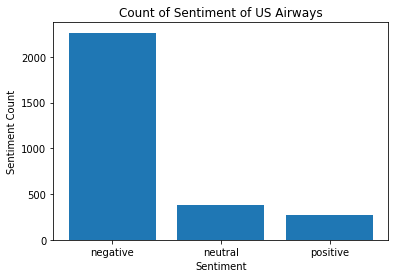

In [8]:
plot_sub_sentiment('US Airways')

In [9]:
def plot_airlines(airlines, plot_func, ncols=3) -> None:
    '''
    INPUT: A list of airline
    OUTPUT: None
    
    Plot all bar chart of all airline in a single figure using plot_func
    '''
    
    # Construct plot and subplots
    plt.figure(figsize=(16,12))
    nrows = math.ceil(len(airlines) / ncols)
    
    for i, airline in enumerate(airlines):
        plt.subplot(nrows, ncols, i + 1)
        plot_func(airline)
    
    plt.tight_layout()

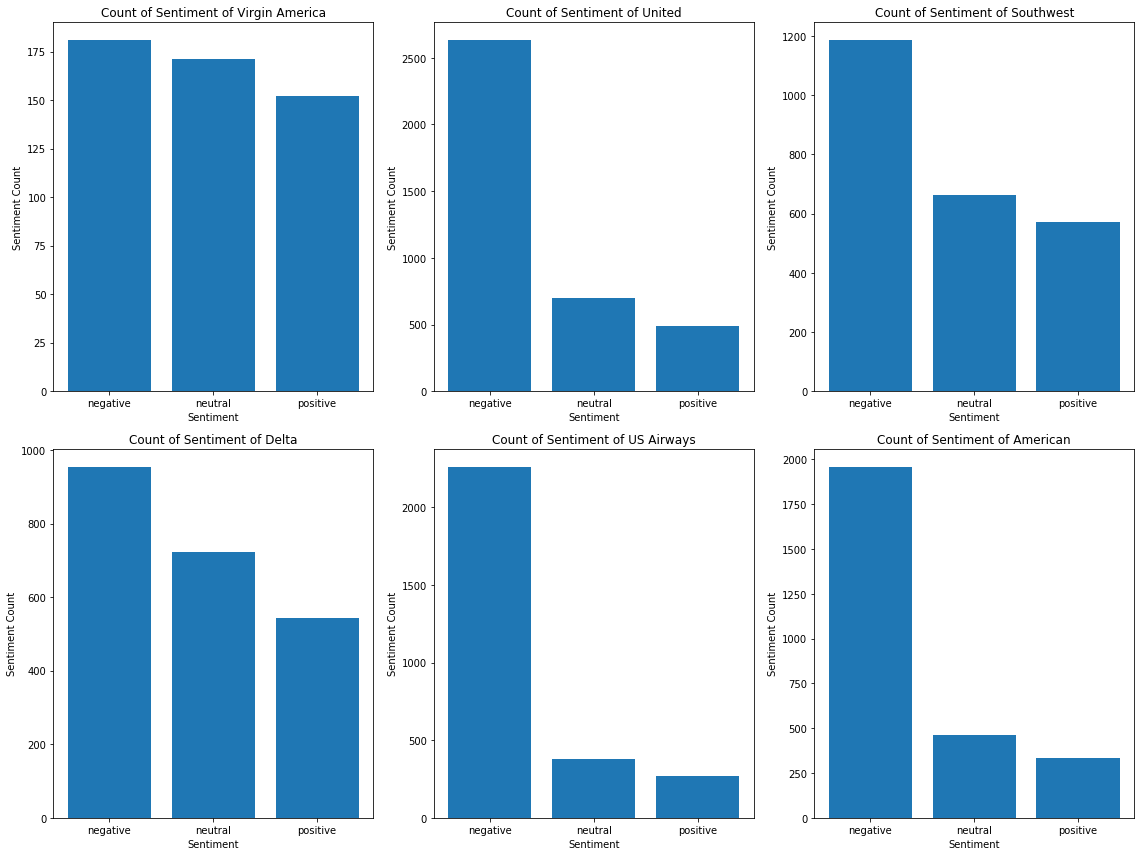

In [10]:
plot_airlines(tweets['airline'].unique(), plot_func=plot_sub_sentiment)

### How to improve customer satisfaction for each US Airline?
Get a list of top complaints

In [11]:
# Top complaints
# Here the negative reason is categorical thus we can do the aggregation

top_complaints = neg['negativereason'].value_counts()
top_complaints

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

As expected, the most complaints is relevant to customer service issues.

#### Plot complaint distribution for each airline

In [12]:
def plot_sub_neg_reasons(airline: str) -> None:
    '''
    INPUT: A list of airline
    OUTPUT: None
    
    Plot a bar chart for the number each negative reason of a given article
    '''
    
    # Get negative reasons count from airline
    df = tweets[tweets['airline'] == airline]
    count = df['negativereason'].value_counts()
    
    # Plot bar
    plt.bar(count.index, count)
    plt.ylabel('Count')
    plt.xticks(count.index, rotation=90)
    plt.xlabel('Reason')
    plt.title('Count of Negative reasons of ' + airline)

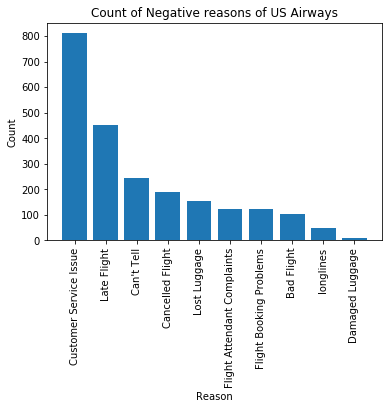

In [13]:
plot_sub_neg_reasons('US Airways')

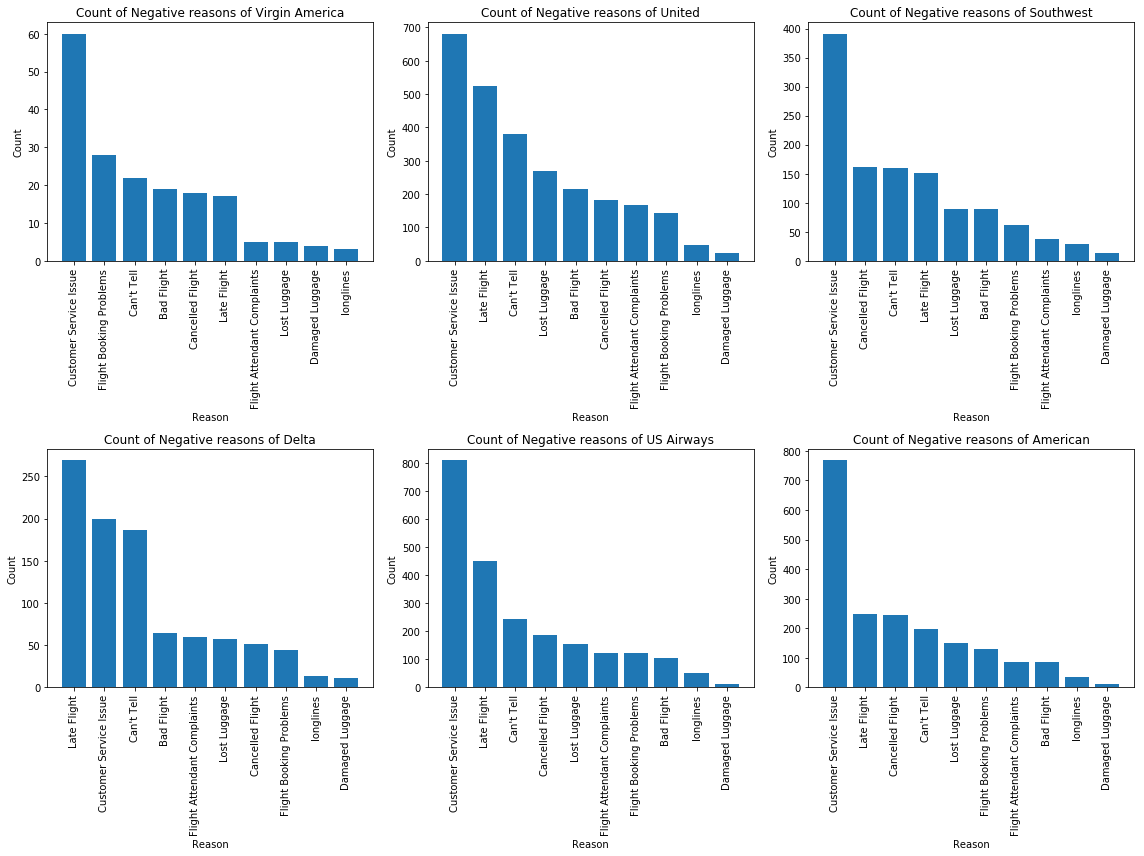

In [14]:
plot_airlines(tweets['airline'].unique(), plot_func=plot_sub_neg_reasons)

All above already can give us a pretty good insights and potential problems of these airlines. However, it's all human rated. If we can make a machine learning classifier, it will save a lot of time and money.

## Sentiment Analysis with SVM

In [15]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

### Get training data
1. We only take negative and positive data for training
2. For quality control, we only take those have high quality confidence

In [16]:
train = tweets.copy()

In [17]:
# For training, we only take tweets with high quality confidence, assuming threshold is 0.65

conf_threshold = 0.65

train = train[train['airline_sentiment'].isin(['positive', 'negative'])]
train = train[train['airline_sentiment_confidence'] > 0.65]

In [18]:
# Append a new column for label (1 for neg, 0 for pos) 
train['sentiment'] = train['airline_sentiment'].apply(lambda x:1 if x == 'negative' else 0)
train.sample(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sentiment
1341,569811013786312704,negative,1.0,Late Flight,1.0,United,NaN,priyadarshy,NaN,0,@united really 1st flt frm IAD 2 IAH is - Late...,NaN,2015-02-23 02:48:26 -0800,US,Quito,1
444,568017135236022273,negative,1.0,Cancelled Flight,1.0,Virgin America,NaN,NickyB617,NaN,0,@VirginAmerica I tried that. You offered to ch...,NaN,2015-02-18 04:00:12 -0800,"Boston, MA",Eastern Time (US & Canada),1


In [19]:
# Check the ratio of training data
train['sentiment'].value_counts()

1    8787
0    2164
Name: sentiment, dtype: int64

In [20]:
X = list(train['text'])
y = list(train['sentiment'])
print('training X:', len(X))
print('training y:', len(y))

training X: 10951
training y: 10951


### Split training data we have into actual training set and validation set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 0,
    stratify = y
)

In [22]:
print('# of train:', len(X_train))
print('# of test:', len(X_test))

# of train: 8760
# of test: 2191


### Convert text into features

In [23]:
# Tokenization and normalization
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()

def tokenize(s: str) -> list:
    '''
    INPUT: a string of sentence
    OUTPUT: a list of words 
    '''
    
    tokens = tokenizer.tokenize(s)
    return [lemmatizer.lemmatize(t) for t in tokens]

In [24]:
cnt_vec = CountVectorizer(
    analyzer='word',        # default, word level vectorization
    tokenizer=tokenize,     # override tokenization method
    ngram_range=(1,1),      # using bag-of-word strategy
    stop_words='english'    # remove English stopwords
)

### Build pipeline and model

In [25]:
np.random.seed(2)

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Setup Linear SVM Classifier 
svc = LinearSVC(class_weight='balanced')

# Build model pipeline, all data will go through this pipeline
pipeline_svc = make_pipeline(cnt_vec, svc)

In [26]:
# Setup grid search to find best parameter C for SVM

grid_svm = GridSearchCV(
    estimator=pipeline_svc,
    param_grid={'linearsvc__C': [0.01, 0.1, 1]},
    cv=kfolds,
    scoring='f1',
    verbose=1,
    n_jobs=-1) # Doing grid search in parallel, -1 means using all kernels

In [27]:
grid_search = grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   16.0s finished
C:\Users\13805\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [28]:
best_score = grid_search.best_score_
print(best_score) # F-score of negative class

0.9508117509932188


In [29]:
best_parameter = grid_search.best_params_
print(best_parameter)

{'linearsvc__C': 0.1}


### Testing

In [30]:
pred_train = grid_svm.predict(X_train)
pred_test = grid_svm.predict(X_test)

In [31]:
# Report for training data
print(classification_report(y_true=y_train, y_pred=pred_train))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1731
           1       1.00      0.98      0.99      7029

   micro avg       0.98      0.98      0.98      8760
   macro avg       0.96      0.99      0.97      8760
weighted avg       0.98      0.98      0.98      8760



In [32]:
# Report for testing data
print(classification_report(y_true=y_test, y_pred=pred_test))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       433
           1       0.97      0.94      0.95      1758

   micro avg       0.92      0.92      0.92      2191
   macro avg       0.87      0.90      0.89      2191
weighted avg       0.93      0.92      0.93      2191



In [33]:
grid_svm.predict(['flying with @united is always a great experience'])

array([0])

In [34]:
grid_svm.predict(['@united sucks!'])

array([1])

In [35]:
grid_svm.predict(['@united very bad experience!'])

array([1])